<a href="https://colab.research.google.com/github/van-william/money-in-bible/blob/main/money_in_bible.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import requests
import string
import seaborn as sns
import matplotlib.pyplot as plt
from string import printable
import re

In [41]:
BOOKS_OLD_TESTAMENT = [
'Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', 'Ruth',
'1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes', 'Song of Solomon', 'Isaiah', 'Jeremiah',
'Lamentations', 'Ezekiel', 'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah',
'Micah', 'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi'
]
BOOKS_NEW_TESTAMENT = [
'Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians', '2 Corinthians',
'Galatians', 'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy',
'Titus', 'Philemon', 'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John',
'3 John', 'Jude', 'Revelation'
]

In [42]:
def printable_string(text):
    """Clean text by removing non-printable characters."""
    return ''.join(char for char in str(text) if char in printable)

def fetch_bible_text(url):
    """Fetch and process Bible text from URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()

        # Process the text
        raw_text = response.text
        text_lines = raw_text.splitlines()

        # Skip header lines
        verse_lines = text_lines[3:]  # Skip first 3 lines

        # Process lines using regex to separate reference from text
        processed_lines = []
        pattern = r'^([\w\s]+\d+:\d+)\s(.+)$'

        for line in verse_lines:
            match = re.match(pattern, line.strip())
            if match:
                reference, text = match.groups()
                processed_lines.append([reference.strip(), text.strip()])
            else:
                continue  # Skip lines that don't match the pattern

        if not processed_lines:
            raise ValueError("No valid verses found in the file")

        # Convert to numpy array
        bible_array = np.array(processed_lines, dtype=object)

        # Clean text
        bible_array[:, 1] = np.array([printable_string(verse) for verse in bible_array[:, 1]])

        # Create DataFrame
        df = pd.DataFrame(bible_array, columns=['reference', 'text'])

        # Remove any empty rows
        df = df.dropna()

        # Verify the data
        print(f"\nFirst few verses:")
        print(df.head())

        return df

    except requests.RequestException as e:
        print(f"Error fetching Bible text: {str(e)}")
        return None
    except Exception as e:
        print(f"Error processing Bible text: {str(e)}")
        print(f"Error type: {type(e)}")
        return None

# Usage
bible_url = 'https://bereanbible.com/bsb.txt'
bible_df = fetch_bible_text(bible_url)

if bible_df is not None:
    print(f"\nSuccessfully loaded Bible text. Shape: {bible_df.shape}")
else:
    print("Failed to load Bible text")


First few verses:
     reference                                               text
0  Genesis 1:1  In the beginning God created the heavens and t...
1  Genesis 1:2  Now the earth was formless and void, and darkn...
2  Genesis 1:3  And God said, Let there be light, and there wa...
3  Genesis 1:4  And God saw that the light was good, and He se...
4  Genesis 1:5  God called the light day, and the darkness He ...

Successfully loaded Bible text. Shape: (31086, 2)


In [43]:
def chapter_split(text):
  reference_list = text.split(' ')
  chapter_verse = reference_list[-1].split(':')
  return int(chapter_verse[0])

def book_split(text):
  book = text.split(' ')
  return ' '.join(book[0:len(book)-1])
bible_df['chapter'] = bible_df['reference'].apply(chapter_split)
bible_df['book'] = bible_df['reference'].apply(book_split)
bible_df['testament'] = bible_df['book'].apply(lambda x: 'OT' if x in BOOKS_OLD_TESTAMENT else 'NT')
bible_df.head()

,reference,text,chapter,book,testament
0,Genesis 1:1,In the beginning God created the heavens and t...,1,Genesis,OT
1,Genesis 1:2,"Now the earth was formless and void, and darkn...",1,Genesis,OT
2,Genesis 1:3,"And God said, Let there be light, and there wa...",1,Genesis,OT
3,Genesis 1:4,"And God saw that the light was good, and He se...",1,Genesis,OT
4,Genesis 1:5,"God called the light day, and the darkness He ...",1,Genesis,OT


In [44]:
# Define a list of words related to money
money_words = ["wealth", "money", "treasure", "riches", "rich", "poor"]

# Convert the text column to lowercase for case-insensitive matching
bible_df["text_lower"] = bible_df["text"].str.lower()

# Function to check if a row contains any money-related words
def contains_money_words(text):
  for word in money_words:
    if word in text:
      return True
  return False

# Apply the function to create the new column 'contains_money'
bible_df["contains_money"] = bible_df["text_lower"].apply(contains_money_words)

In [45]:
bible_df.head()

,reference,text,chapter,book,testament,text_lower,contains_money
0,Genesis 1:1,In the beginning God created the heavens and t...,1,Genesis,OT,in the beginning god created the heavens and t...,False
1,Genesis 1:2,"Now the earth was formless and void, and darkn...",1,Genesis,OT,"now the earth was formless and void, and darkn...",False
2,Genesis 1:3,"And God said, Let there be light, and there wa...",1,Genesis,OT,"and god said, let there be light, and there wa...",False
3,Genesis 1:4,"And God saw that the light was good, and He se...",1,Genesis,OT,"and god saw that the light was good, and he se...",False
4,Genesis 1:5,"God called the light day, and the darkness He ...",1,Genesis,OT,"god called the light day, and the darkness he ...",False


In [46]:
# Group the dataframe by testament and book.
grouped_df = bible_df.groupby(['testament', 'book'])

# Sum the 'contains_money' column for each group.  Since contains money is boolean,
# summing it will give the number of times it is true in each group
summed_df = grouped_df['contains_money'].sum()


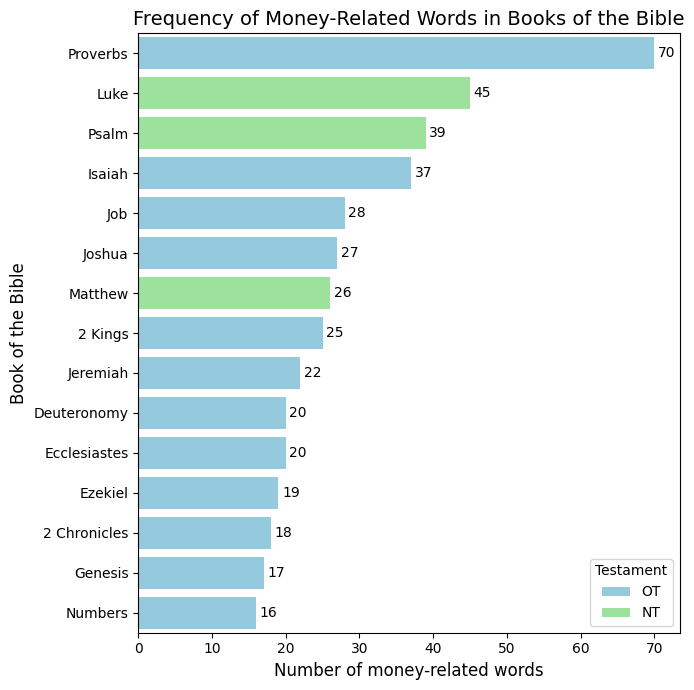

In [47]:
plt.figure(figsize=(7, 7))
max_books = 15

# Create the bar plot with Seaborn
sns.barplot(x=summed_df.sort_values(ascending=False)[0:max_books].values,
            y=summed_df.sort_values(ascending=False)[0:max_books].index.get_level_values('book'),
            hue=summed_df.sort_values(ascending=False)[0:max_books].index.get_level_values('testament'),
            palette={"OT": "skyblue", "NT": "lightgreen"}) # Use different colors for OT and NT

plt.xlabel("Number of money-related words", fontsize=12)  # add x label with increased font size
plt.ylabel("Book of the Bible", fontsize=12)  # add y label with increased font size
plt.title("Frequency of Money-Related Words in Books of the Bible", fontsize=14)  # add title with increased font size
plt.xticks(fontsize=10) # adjust xtick font size
plt.yticks(fontsize=10) # adjust ytick font size

# Add data labels with better formatting
for i, v in enumerate(summed_df.sort_values(ascending=False)[0:max_books]):
    plt.text(v + 0.5, i, str(v), color='black', va='center', fontsize=10)  # add data labels with increased font size and black color

plt.legend(title="Testament", fontsize=10) #add legend with title and fontsize
plt.tight_layout() # adjust layout to prevent labels from overlapping
plt.show()